In [3]:
import chess.pgn
import os

LIMIT = 500

pgn = open(os.path.join('data', 'lichess_db_standard_rated_2013-01.pgn'))
games = []
for _ in range(LIMIT):
    game = chess.pgn.read_game(pgn)
    games.append(game)
print(len(games))

500


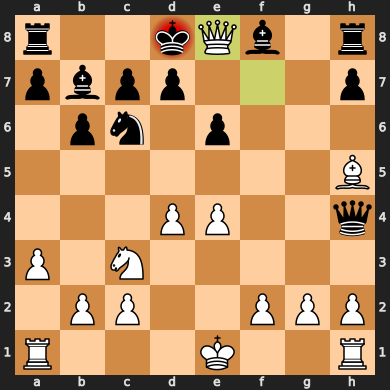

In [2]:
board = games[0].board()
for move in games[0].mainline_moves():
    board.push(move)

board

In [4]:
from stockfish import Stockfish

stockfish = Stockfish(os.path.join('bin', 'stockfish_14_x64'))
stockfish.set_position(['e2e4', 'e7e6'])
stockfish.get_top_moves(3)

[{'Move': 'd2d4', 'Centipawn': 97, 'Mate': None},
 {'Move': 'b1c3', 'Centipawn': 71, 'Mate': None},
 {'Move': 'g1f3', 'Centipawn': 71, 'Mate': None}]

In [5]:
def value(piece):
    if not piece:
        return 0
    elif piece.piece_type == chess.PAWN:
        return 1
    elif piece.piece_type == chess.KNIGHT:
        return 3
    elif piece.piece_type == chess.BISHOP:
        return 3
    elif piece.piece_type == chess.ROOK:
        return 5
    elif piece.piece_type == chess.QUEEN:
        return 9
    else:
        return 0

In [6]:
def fork(board):
    match = False
    suggestions = []
    for move in board.legal_moves:
        if board.piece_type_at(move.from_square) == chess.KING:
            continue
        board.push(move)
        board.push(chess.Move.null())
        nb = 0
        # print(move, chess.square_name(move.to_square), board.attacks(move.to_square))
        for attacks in board.attacks(move.to_square):
            attacked_piece = board.piece_at(attacks)
            # print(chess.square_name(attacks), attacked_piece, value(attacked_piece))
            if value(attacked_piece) > 1:
                nb += 1
        board.pop()
        board.pop()
        if nb > 1:
            match = True
            suggestions.append(move)
    return match, suggestions[:3]

In [7]:
def get_evals(engine, board, suggestions):
    evals = []
    for suggested_move in suggestions:
        board.push(suggested_move)
        engine.set_fen_position(board.fen())
        evaluation = engine.get_evaluation()
        evals.append((evaluation['type'], evaluation['value']))
        board.pop()
    return evals

In [9]:
def get_top_n_moves(engine, n, board):
    engine.set_fen_position(board.fen())
    return engine.get_top_moves(n)

In [58]:
for game in games:
    board = game.board()
    for move in game.mainline_moves():
        board.push(move)
        match, suggestions = fork(board)
        if match:
            evals = get_evals(stockfish, board, suggestions)
            print(board.fen(), match, list(zip(suggestions, evals)))

rn1qkbnr/pbpp1ppp/1p2p3/8/3PP3/P1N5/1PP2PPP/R1BQKBNR b KQkq - 2 4 True [(Move.from_uci('d8c8'), ('cp', 362))]
rn1qkb1r/pbpp1ppp/1p2p2n/8/3PP3/P1N5/1PP2PPP/R1BQKBNR w KQkq - 3 5 True [(Move.from_uci('c3e2'), ('cp', -66)), (Move.from_uci('g1e2'), ('cp', 146)), (Move.from_uci('d1d3'), ('cp', 114))]
rn1qkb1r/pbpp1ppp/1p2p2B/8/3PP3/P1N5/1PP2PPP/R2QKBNR b KQkq - 0 5 True [(Move.from_uci('d8c8'), ('cp', 1362))]
rn1qkb1r/pbpp1p1p/1p2p2p/8/3PP3/P1N5/1PP2PPP/R2QKBNR w KQkq - 0 6 True [(Move.from_uci('d1d3'), ('cp', 95))]
rn1qkb1r/pbpp1p1p/1p2p2p/8/3PP3/P1N5/1PP1BPPP/R2QK1NR b KQkq - 1 6 True [(Move.from_uci('d8c8'), ('cp', 472))]
rn2kb1r/pbpp1p1p/1p2p2p/6q1/3PP3/P1N5/1PP1BPPP/R2QK1NR w KQkq - 2 7 True [(Move.from_uci('d1d3'), ('cp', -630)), (Move.from_uci('d1d2'), ('cp', -630)), (Move.from_uci('d1c1'), ('cp', -661))]
rn2kb1r/pbpp1p1p/1p2p2p/6q1/3PP1B1/P1N5/1PP2PPP/R2QK1NR b KQkq - 3 7 True [(Move.from_uci('h8g8'), ('cp', 189)), (Move.from_uci('g5g8'), ('cp', 441)), (Move.from_uci('g5g7'), ('cp',

In [14]:
import math

def evaluate(evaluated_suggestions, top_moves):
    dcg = 0
    for idx, (evaluated_move, top_move) in enumerate(zip(evaluated_suggestions, top_moves)):
        eval = evaluated_move[1][1] # doesn't account for mate evals
        top_eval = top_move['Centipawn']
        dcg += abs(top_eval - eval) / math.log2(1 + (idx + 1))
    return dcg

In [16]:
board = chess.Board('r1bqkb1r/pppp1ppp/2n5/4p3/4P1n1/2NP1N2/PPP2PPP/R1BQKB1R w KQkq - 1 5')
match, suggestions = fork(board)
top_moves = get_top_n_moves(stockfish, len(suggestions), board)
if match:
    evals = get_evals(stockfish, board, suggestions)
    print(board.fen(), match, list(zip(suggestions, evals)), top_moves)
print(evaluate(zip(suggestions, evals), top_moves))

r1bqkb1r/pppp1ppp/2n5/4p3/4P1n1/2NP1N2/PPP2PPP/R1BQKB1R w KQkq - 1 5 True [(Move.from_uci('f3e5'), ('cp', -571)), (Move.from_uci('f1e2'), ('cp', -235)), (Move.from_uci('d1e2'), ('cp', -225))] [{'Move': 'h2h3', 'Centipawn': 1207, 'Mate': None}, {'Move': 'c1g5', 'Centipawn': 792, 'Mate': None}, {'Move': 'c3d5', 'Centipawn': 96, 'Mate': None}]
2586.4648569178867
